In [ ]:
import pandas as pd
pd.set_option('display.width', 1000)
df = pd.read_csv('/content/drive/MyDrive/cleaned_processed_user_datav4_filtered_cleaned.csv')

# To see the column names
print("Column names:", df.columns)

# To see the first row
print("First row:\n", df.iloc[0])

Column names: Index(['OwnerUserId', 'RowCount', 'Tags_y', 'CreationDate', 'Score'], dtype='object')
First row:
 OwnerUserId                                                     1
RowCount                                                       15
Tags_y          [['optimization'], ['algorithm', 'string'], ['...
CreationDate    [Timestamp('2008-08-14 03:13:56.770000'), Time...
Score                       [6, 4, 496, 3, 5, 7, 1, 1, 1, 13, 23]
Name: 0, dtype: object


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-processing

In [ ]:
# Data Cleaning
# Normalize the timestamps to a consistent format
#df['CreationDate'] = df['CreationDate'].apply(lambda x: [pd.Timestamp(ts) for ts in eval(x)])

# Ensure that the tags are in a usable format (e.g., list of strings)
#df['Tags_y'] = df['Tags_y'].apply(lambda x: eval(x)[0])

# Handle missing values if any
data = df.dropna()

# Save the cleaned data
data.to_csv('processed_data.csv', index=False)

## Score Calculation

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import regex as re

def calculate_time_score(timestamp, oldest_timestamp):
    if timestamp is None or oldest_timestamp is None:
        return 0
    time_diff = (timestamp - oldest_timestamp).total_seconds()
    return time_diff

def calculate_combined_score(time_score, actual_score, su, time_weight=0.6, score_weight=0.4):
    normalized_time_score = time_score / max(time_score, 1)
    normalized_actual_score = actual_score / max(su, 1)
    return (time_weight * normalized_time_score) + (score_weight * normalized_actual_score)

def process_row(row):
    tags = row['Tags_y']
    timestamps = row['CreationDate']
    scores = row['Score']
    string_input = scores.strip().strip('[]')
    # Split the string by comma and convert each item to int
    scores = [int(item.strip()) for item in string_input.split(',') if item.strip()]

    result = ast.literal_eval(tags)

    # Ensure all elements are lists of strings
    tags = [[str(item) for item in sublist] for sublist in result]

    print(f"\nProcessing row:")
    print(f"Tags: {tags}")
    print(f"Timestamps: {timestamps}")
    print(f"Scores: {scores}")

    timestamp_pattern = r"Timestamp\('(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{6})'\)"

    # Find all matches in the large string
    matches = re.findall(timestamp_pattern, timestamps)

    # Convert each match to a pandas.Timestamp object
    parsed_timestamps = []
    for match in matches:
        try:
            parsed_timestamps.append(pd.Timestamp(match))
        except ValueError as e:
            print(f"Error parsing timestamp: {e} for match: {match}")

    valid_data = [(tag, ts, score) for tag, ts, score in zip(tags, parsed_timestamps, scores) if ts is not None]

    if not valid_data:
        print("No valid data in this row")
        return []

    tags, timestamps, scores = zip(*valid_data)
    oldest_timestamp = min(timestamps)
    su = sum(scores)
    time_scores = [calculate_time_score(ts, oldest_timestamp) for ts in timestamps]
    combined_scores = [calculate_combined_score(ts, s, su) for ts, s in zip(time_scores, scores)]


    sorted_tags = [tag for _, tag in sorted(zip(combined_scores, tags), reverse=True)]

    flattened_tags = [item for sublist in sorted_tags for item in sublist]
    unique_tags = []
    seen = set()
    for tag in flattened_tags:
        if tag not in seen:
            unique_tags.append(tag)
            seen.add(tag)

    print(f"Resulting tag sequence: {unique_tags}")
    return unique_tags

In [ ]:
df['tag_sequence'] = df.apply(process_row, axis=1)

Streaming output truncated to the last 5000 lines.
Scores: [0]
Resulting tag sequence: ['arrays']

Processing row:
Tags: [['arrays']]
Timestamps: [Timestamp('2023-11-23 09:44:49.150000')]
Scores: [0]
Resulting tag sequence: ['arrays']

Processing row:
Tags: [['arrays'], ['recursion'], ['arrays', 'recursion'], ['arrays'], ['recursion']]
Timestamps: [Timestamp('2023-12-15 02:23:08.377000'), Timestamp('2023-12-22 03:04:44.897000'), Timestamp('2023-12-19 03:28:28.210000'), Timestamp('2024-01-16 02:10:55.917000'), Timestamp('2024-03-18 07:29:07.090000')]
Scores: [0, 1, 1, 0, 2]
Resulting tag sequence: ['recursion', 'arrays']

Processing row:
Tags: [['list']]
Timestamps: [Timestamp('2023-11-23 11:24:33.567000')]
Scores: [2]
Resulting tag sequence: ['list']

Processing row:
Tags: [['list']]
Timestamps: [Timestamp('2024-03-21 18:34:46.400000')]
Scores: [1]
Resulting tag sequence: ['list']

Processing row:
Tags: [['data-structures']]
Timestamps: [Timestamp('2023-11-24 22:47:28.343000'), Timesta

In [ ]:
df['CreationDate'].count()

499546

In [ ]:
print(type(df['tag_sequence'][0]))

<class 'list'>


## Synthetic Data

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

def analyze_sequences(sequences):
    all_tags = set()
    tag_counts = Counter()
    tag_positions = {}
    sequence_lengths = []

    for sequence in tqdm(sequences, desc="Analyzing sequences"):
        sequence_lengths.append(len(sequence))
        all_tags.update(sequence)
        tag_counts.update(sequence)

        for i, tag in enumerate(sequence):
            if tag not in tag_positions:
                tag_positions[tag] = []
            tag_positions[tag].append(i / len(sequence))

    tag_stats = {}
    for tag in all_tags:
        positions = tag_positions.get(tag, [])
        tag_stats[tag] = {
            'count': tag_counts[tag],
            'mean_pos': np.mean(positions) if positions else 0,
            'std_pos': np.std(positions) if positions else 0,
            'prob': tag_counts[tag] / sum(tag_counts.values())
        }

    return tag_stats, np.mean(sequence_lengths), np.std(sequence_lengths)

def generate_synthetic_sequence(tag_stats, mean_length, std_length, min_length=75):
    length = max(int(np.random.normal(mean_length, std_length)), min_length)

    synthetic_sequence = []

    for i in range(length):
        pos = i / length
        tag_probs = []
        for tag, stats in tag_stats.items():
            prob = stats['prob'] * np.exp(-((pos - stats['mean_pos']) ** 2) / (2 * max(stats['std_pos'], 0.1) ** 2))
            tag_probs.append((tag, prob))

        tags, probs = zip(*tag_probs)
        probs = np.array(probs) / sum(probs)
        chosen_tag = np.random.choice(tags, p=probs)

        synthetic_sequence.append(chosen_tag)

    return synthetic_sequence

def process_dataframe_column(df, column_name):
    if isinstance(df[column_name].iloc[0], list):
        all_sequences = df[column_name].tolist()
    else:
        try:
            all_sequences = df[column_name].apply(eval).tolist()
        except:
            raise ValueError(f"Column '{column_name}' must contain lists or string representations of lists")

    tag_stats, mean_length, std_length = analyze_sequences(all_sequences)

    return tag_stats, mean_length, std_length

# Example usage with your DataFrame
# Assuming df is your DataFrame and 'tag_sequence' is your column name
tag_stats, mean_length, std_length = process_dataframe_column(df, 'tag_sequence')

print("Tag statistics:")
for tag, stats in tag_stats.items():
    print(f"\nTag: {tag}")
    print(f"Count: {stats['count']}, Mean Position: {stats['mean_pos']:.2f}, Std Position: {stats['std_pos']:.2f}, Probability: {stats['prob']:.4f}")

print(f"\nMean sequence length: {mean_length:.2f}")
print(f"Std sequence length: {std_length:.2f}")

# Generate synthetic sequences
num_synthetic = 10000  # Increased number of synthetic sequences
synthetic_sequences = [generate_synthetic_sequence(tag_stats, mean_length, std_length, min_length=75)
                       for _ in tqdm(range(num_synthetic), desc="Generating synthetic sequences")]

print("\nSynthetic sequence lengths:")
print(f"Min: {min(len(seq) for seq in synthetic_sequences)}")
print(f"Max: {max(len(seq) for seq in synthetic_sequences)}")
print(f"Mean: {np.mean([len(seq) for seq in synthetic_sequences]):.2f}")

# Analyze synthetic sequences
synthetic_df = pd.DataFrame({'sequence': synthetic_sequences})
synthetic_stats, syn_mean_length, syn_std_length = process_dataframe_column(synthetic_df, 'sequence')

print("\nComparison of original vs synthetic statistics:")
print(f"Original - Mean length: {mean_length:.2f}, Std length: {std_length:.2f}")
print(f"Synthetic - Mean length: {syn_mean_length:.2f}, Std length: {syn_std_length:.2f}")

for tag in set(tag_stats.keys()) | set(synthetic_stats.keys()):
    print(f"\nTag: {tag}")
    if tag in tag_stats:
        print(f"Original - Count: {tag_stats[tag]['count']}, Mean Position: {tag_stats[tag]['mean_pos']:.2f}, Std Position: {tag_stats[tag]['std_pos']:.2f}, Probability: {tag_stats[tag]['prob']:.4f}")
    if tag in synthetic_stats:
        print(f"Synthetic - Count: {synthetic_stats[tag]['count']}, Mean Position: {synthetic_stats[tag]['mean_pos']:.2f}, Std Position: {synthetic_stats[tag]['std_pos']:.2f}, Probability: {synthetic_stats[tag]['prob']:.4f}")

# Save synthetic data to CSV
#synthetic_df.to_csv('synthetic_sequences.csv', index=False)
#print("\nSynthetic sequences saved to 'synthetic_sequences.csv'")

Analyzing sequences: 100%|██████████| 499546/499546 [00:01<00:00, 380727.85it/s]


Tag statistics:

Tag: dynamic-arrays
Count: 2325, Mean Position: 0.52, Std Position: 0.29, Probability: 0.0019

Tag: euler-path
Count: 29, Mean Position: 0.67, Std Position: 0.21, Probability: 0.0000

Tag: tree-traversal
Count: 1235, Mean Position: 0.57, Std Position: 0.26, Probability: 0.0010

Tag: graph-query
Count: 7, Mean Position: 0.41, Std Position: 0.37, Probability: 0.0000

Tag: treenode
Count: 787, Mean Position: 0.42, Std Position: 0.32, Probability: 0.0007

Tag: radix-sort
Count: 391, Mean Position: 0.57, Std Position: 0.25, Probability: 0.0003

Tag: hash-function
Count: 396, Mean Position: 0.55, Std Position: 0.28, Probability: 0.0003

Tag: treepath
Count: 11, Mean Position: 0.53, Std Position: 0.23, Probability: 0.0000

Tag: dynamic-allocation
Count: 840, Mean Position: 0.54, Std Position: 0.29, Probability: 0.0007

Tag: floyd-warshall
Count: 222, Mean Position: 0.61, Std Position: 0.24, Probability: 0.0002

Tag: heap-size
Count: 149, Mean Position: 0.40, Std Position: 0.3

Generating synthetic sequences: 100%|██████████| 10000/10000 [09:51<00:00, 16.90it/s]



Synthetic sequence lengths:
Min: 75
Max: 75
Mean: 75.00


Analyzing sequences: 100%|██████████| 10000/10000 [00:00<00:00, 21595.48it/s]



Comparison of original vs synthetic statistics:
Original - Mean length: 2.39, Std length: 3.49
Synthetic - Mean length: 75.00, Std length: 0.00

Tag: dynamic-arrays
Original - Count: 2325, Mean Position: 0.52, Std Position: 0.29, Probability: 0.0019
Synthetic - Count: 2325, Mean Position: 0.67, Std Position: 0.25, Probability: 0.0031

Tag: graph-query
Original - Count: 7, Mean Position: 0.41, Std Position: 0.37, Probability: 0.0000
Synthetic - Count: 4, Mean Position: 0.44, Std Position: 0.32, Probability: 0.0000

Tag: treenode
Original - Count: 787, Mean Position: 0.42, Std Position: 0.32, Probability: 0.0007
Synthetic - Count: 736, Mean Position: 0.60, Std Position: 0.28, Probability: 0.0010

Tag: treepath
Original - Count: 11, Mean Position: 0.53, Std Position: 0.23, Probability: 0.0000
Synthetic - Count: 12, Mean Position: 0.79, Std Position: 0.12, Probability: 0.0000

Tag: dynamic-allocation
Original - Count: 840, Mean Position: 0.54, Std Position: 0.29, Probability: 0.0007
Synth

In [ ]:
synthetic_df

,sequence
0,"[arrays, matrix-multiplication, sorting, algor..."
1,"[recursion, arrays, string, string, string, se..."
2,"[arrays, list, list, boolean, linked-list, arr..."
3,"[arrays, string, list, data-structures, arrays..."
4,"[substring, minimum-spanning-tree, graph, sort..."
...,...
9995,"[string, subset-sum, partitioning, knapsack-pr..."
9996,"[arrays, list, string, arrays, substring, arra..."
9997,"[arrays, linked-list, list, data-structures, s..."
9998,"[string, algorithm, arrays, hash, list, algori..."


In [ ]:
synthetic_df['sequence'][4]

['substring',
 'minimum-spanning-tree',
 'graph',
 'sorting',
 'string',
 'string',
 'boolean',
 'memory-management',
 'arrays',
 'string',
 'heap-memory',
 'string',
 'arrays',
 'string',
 'artificial-intelligence',
 'string',
 'algorithm',
 'algorithm',
 'arrays',
 'probability',
 'string',
 'arrays',
 'list',
 'string',
 'arrays',
 'arrays',
 'recursion',
 'set',
 'sorting',
 'dynamic-programming',
 'substring',
 'hash',
 'recursion',
 'algorithm',
 'data-structures',
 'big-o',
 'recursion',
 'algorithm',
 'hash',
 'algorithm',
 'dijkstra',
 'algorithm',
 'string',
 'string',
 'bubble-sort',
 'set',
 'automata',
 'sorting',
 'list',
 'string',
 'artificial-intelligence',
 'sorting',
 'multidimensional-array',
 'insertion-sort',
 'multidimensional-array',
 'arrays',
 'memory-management',
 'directed-graph',
 'boolean',
 'algorithm',
 'substring',
 'hash',
 'algorithm',
 'set',
 'depth-first-search',
 'list',
 'dynamic-arrays',
 'optimization',
 'quicksort',
 'dynamic-allocation',
 'tr

In [ ]:
synthetic_df.to_csv('synthetic_sequences.csv', index=False)
print("\nSynthetic sequences saved to 'synthetic_sequences.csv'")


Synthetic sequences saved to 'synthetic_sequences.csv'


### Sequence length reflecting distribution



In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
from scipy import stats

In [ ]:
def analyze_sequences(sequences):
    all_tags = set()
    tag_counts = Counter()
    tag_positions = {}
    sequence_lengths = []

    for sequence in tqdm(sequences, desc="Analyzing sequences"):
        sequence_lengths.append(len(sequence))
        all_tags.update(sequence)
        tag_counts.update(sequence)

        for i, tag in enumerate(sequence):
            if tag not in tag_positions:
                tag_positions[tag] = []
            tag_positions[tag].append(i / len(sequence))

    tag_stats = {}
    for tag in all_tags:
        positions = tag_positions.get(tag, [])
        tag_stats[tag] = {
            'count': tag_counts[tag],
            'mean_pos': np.mean(positions) if positions else 0,
            'std_pos': np.std(positions) if positions else 0,
            'prob': tag_counts[tag] / sum(tag_counts.values())
        }

    # Use a histogram for length distribution instead of KDE
    hist, bin_edges = np.histogram(sequence_lengths, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return tag_stats, np.mean(sequence_lengths), np.std(sequence_lengths), (hist, bin_centers)

In [ ]:
def generate_synthetic_sequence(tag_stats, length_dist):
    hist, bin_centers = length_dist
    length = max(1, int(np.random.choice(bin_centers, p=hist/sum(hist))))  # Ensure minimum length of 1

    synthetic_sequence = []

    for i in range(length):
        pos = i / length
        tag_probs = []
        for tag, stats in tag_stats.items():
            prob = stats['prob'] * np.exp(-((pos - stats['mean_pos']) ** 2) / (2 * max(stats['std_pos'], 0.1) ** 2))
            tag_probs.append((tag, prob))

        tags, probs = zip(*tag_probs)
        probs = np.array(probs) / sum(probs)
        chosen_tag = np.random.choice(tags, p=probs)

        synthetic_sequence.append(chosen_tag)

    return synthetic_sequence

In [ ]:
def process_dataframe_column(df, column_name):
    if isinstance(df[column_name].iloc[0], list):
        all_sequences = df[column_name].tolist()
    else:
        try:
            all_sequences = df[column_name].apply(eval).tolist()
        except:
            raise ValueError(f"Column '{column_name}' must contain lists or string representations of lists")

    tag_stats, mean_length, std_length, length_kde = analyze_sequences(all_sequences)

    return tag_stats, mean_length, std_length, length_kde

In [ ]:
tag_stats, mean_length, std_length, length_dist = process_dataframe_column(df, 'tag_sequence')

print("Tag statistics:")
for tag, stats in tag_stats.items():
    print(f"\nTag: {tag}")
    print(f"Count: {stats['count']}, Mean Position: {stats['mean_pos']:.2f}, Std Position: {stats['std_pos']:.2f}, Probability: {stats['prob']:.4f}")

print(f"\nMean sequence length: {mean_length:.2f}")
print(f"Std sequence length: {std_length:.2f}")

Analyzing sequences: 100%|██████████| 499546/499546 [00:01<00:00, 340187.16it/s]


Tag statistics:

Tag: dynamic-programming
Count: 5277, Mean Position: 0.50, Std Position: 0.27, Probability: 0.0044

Tag: hash-function
Count: 396, Mean Position: 0.55, Std Position: 0.28, Probability: 0.0003

Tag: strassen
Count: 92, Mean Position: 0.54, Std Position: 0.29, Probability: 0.0001

Tag: linear-search
Count: 467, Mean Position: 0.58, Std Position: 0.26, Probability: 0.0004

Tag: lifo
Count: 81, Mean Position: 0.51, Std Position: 0.27, Probability: 0.0001

Tag: array-merge
Count: 1348, Mean Position: 0.55, Std Position: 0.25, Probability: 0.0011

Tag: memory-management
Count: 24234, Mean Position: 0.30, Std Position: 0.30, Probability: 0.0203

Tag: turing-complete
Count: 276, Mean Position: 0.38, Std Position: 0.29, Probability: 0.0002

Tag: treenode
Count: 787, Mean Position: 0.42, Std Position: 0.32, Probability: 0.0007

Tag: hashmap
Count: 16591, Mean Position: 0.35, Std Position: 0.30, Probability: 0.0139

Tag: combinatorics
Count: 3075, Mean Position: 0.52, Std Positio

In [ ]:
num_synthetic = 10000  # Increased number of synthetic sequences
synthetic_sequences = [generate_synthetic_sequence(tag_stats, length_dist)
                       for _ in tqdm(range(num_synthetic), desc="Generating synthetic sequences")]

Generating synthetic sequences: 100%|██████████| 10000/10000 [00:29<00:00, 336.32it/s]


In [ ]:
print("\nSynthetic sequence lengths:")
print(f"Min: {min(len(seq) for seq in synthetic_sequences)}")
print(f"Max: {max(len(seq) for seq in synthetic_sequences)}")
print(f"Mean: {np.mean([len(seq) for seq in synthetic_sequences]):.2f}")


Synthetic sequence lengths:
Min: 1
Max: 68
Mean: 2.28


In [ ]:
synthetic_df = pd.DataFrame({'sequence': synthetic_sequences})
synthetic_stats, syn_mean_length, syn_std_length, syn_length_dist = process_dataframe_column(synthetic_df, 'sequence')

print("\nComparison of original vs synthetic statistics:")
print(f"Original - Mean length: {mean_length:.2f}, Std length: {std_length:.2f}")
print(f"Synthetic - Mean length: {syn_mean_length:.2f}, Std length: {syn_std_length:.2f}")

Analyzing sequences: 100%|██████████| 10000/10000 [00:00<00:00, 183432.93it/s]


Comparison of original vs synthetic statistics:
Original - Mean length: 2.39, Std length: 3.49
Synthetic - Mean length: 2.28, Std length: 3.18


In [ ]:
for tag in set(tag_stats.keys()) | set(synthetic_stats.keys()):
    print(f"\nTag: {tag}")
    if tag in tag_stats:
        print(f"Original - Count: {tag_stats[tag]['count']}, Mean Position: {tag_stats[tag]['mean_pos']:.2f}, Std Position: {tag_stats[tag]['std_pos']:.2f}, Probability: {tag_stats[tag]['prob']:.4f}")
    if tag in synthetic_stats:
        print(f"Synthetic - Count: {synthetic_stats[tag]['count']}, Mean Position: {synthetic_stats[tag]['mean_pos']:.2f}, Std Position: {synthetic_stats[tag]['std_pos']:.2f}, Probability: {synthetic_stats[tag]['prob']:.4f}")


Tag: strassen
Original - Count: 92, Mean Position: 0.54, Std Position: 0.29, Probability: 0.0001
Synthetic - Count: 4, Mean Position: 0.50, Std Position: 0.36, Probability: 0.0002

Tag: lifo
Original - Count: 81, Mean Position: 0.51, Std Position: 0.27, Probability: 0.0001
Synthetic - Count: 2, Mean Position: 0.55, Std Position: 0.05, Probability: 0.0001

Tag: memory-management
Original - Count: 24234, Mean Position: 0.30, Std Position: 0.30, Probability: 0.0203
Synthetic - Count: 470, Mean Position: 0.29, Std Position: 0.28, Probability: 0.0206

Tag: turing-complete
Original - Count: 276, Mean Position: 0.38, Std Position: 0.29, Probability: 0.0002
Synthetic - Count: 6, Mean Position: 0.42, Std Position: 0.24, Probability: 0.0003

Tag: counting-sort
Original - Count: 146, Mean Position: 0.60, Std Position: 0.26, Probability: 0.0001
Synthetic - Count: 3, Mean Position: 0.70, Std Position: 0.13, Probability: 0.0001

Tag: balanced-binary-search-tree
Original - Count: 4, Mean Position: 0

In [ ]:
synthetic_df

,sequence
0,[arrays]
1,[boolean]
2,[arrays]
3,"[arrays, set]"
4,[directed-acyclic-graphs]
...,...
9995,"[list, string]"
9996,"[arrays, shortest-path, huffman-code]"
9997,"[sorting, data-structures]"
9998,[list]


In [ ]:
synthetic_df.to_csv('synthetic_sequences.csv', index=False)
print("\nSynthetic sequences saved to 'synthetic_sequences.csv'")


Synthetic sequences saved to 'synthetic_sequences.csv'


## Frequency Analysis

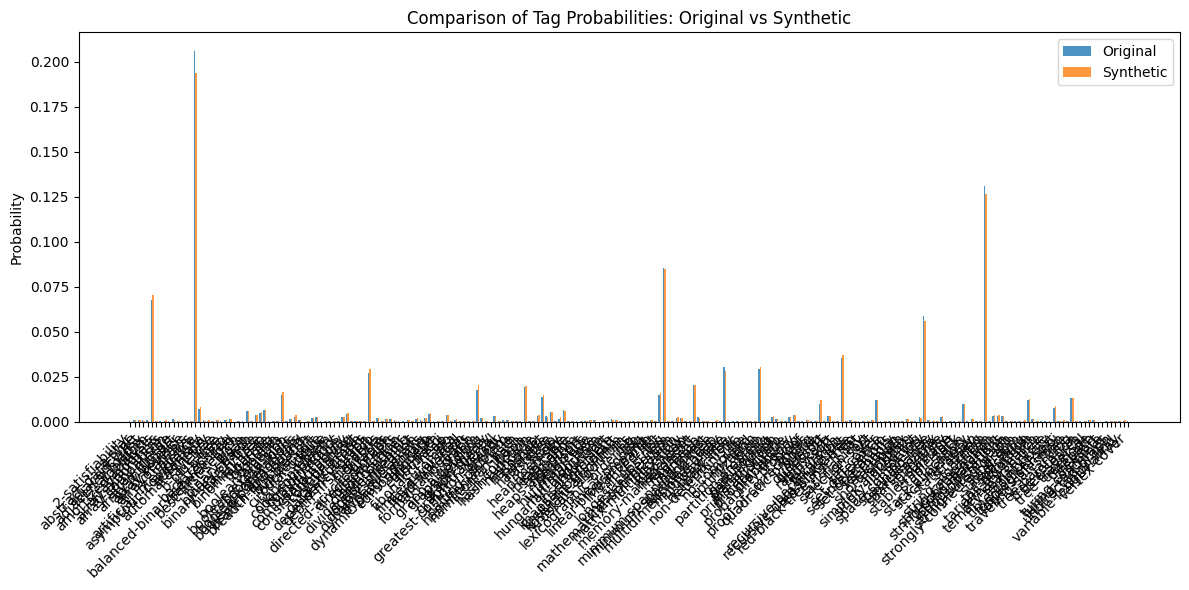

In [ ]:
import matplotlib.pyplot as plt

def compare_tag_distributions(original_stats, synthetic_stats):
    # Get all unique tags
    all_tags = set(original_stats.keys()) | set(synthetic_stats.keys())

    # Prepare data for plotting
    tags = sorted(all_tags)
    original_probs = [original_stats.get(tag, {'prob': 0})['prob'] for tag in tags]
    synthetic_probs = [synthetic_stats.get(tag, {'prob': 0})['prob'] for tag in tags]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the bars
    x = range(len(tags))
    width = 0.35
    ax.bar([i - width/2 for i in x], original_probs, width, label='Original', alpha=0.8)
    ax.bar([i + width/2 for i in x], synthetic_probs, width, label='Synthetic', alpha=0.8)

    # Customize the plot
    ax.set_ylabel('Probability')
    ax.set_title('Comparison of Tag Probabilities: Original vs Synthetic')
    ax.set_xticks(x)
    ax.set_xticklabels(tags, rotation=45, ha='right')
    ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# After generating the statistics, call the function
compare_tag_distributions(tag_stats, synthetic_stats)

In [ ]:
from collections import Counter

def check_exact_matches(original_sequences, synthetic_sequences):
    # Convert original sequences to a set for faster lookup
    original_set = set(tuple(seq) for seq in original_sequences)

    # Count exact matches
    exact_matches = sum(1 for seq in synthetic_sequences if tuple(seq) in original_set)

    # Count unique exact matches
    unique_matches = len(set(tuple(seq) for seq in synthetic_sequences if tuple(seq) in original_set))

    return exact_matches, unique_matches

In [ ]:
original_sequences = df['tag_sequence'].tolist()
exact_matches, unique_matches = check_exact_matches(original_sequences, synthetic_sequences)

print("\nExact match analysis:")
print(f"Total synthetic sequences: {num_synthetic}")
print(f"Number of exact matches: {exact_matches}")
print(f"Percentage of exact matches: {exact_matches/num_synthetic*100:.2f}%")
print(f"Number of unique exact matches: {unique_matches}")
print(f"Percentage of unique exact matches: {unique_matches/num_synthetic*100:.2f}%")


Exact match analysis:
Total synthetic sequences: 10000
Number of exact matches: 8015
Percentage of exact matches: 80.15%
Number of unique exact matches: 1184
Percentage of unique exact matches: 11.84%


## Introducing Randomness

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

def analyze_sequences(sequences):
    all_tags = set()
    tag_counts = Counter()
    tag_positions = {}
    sequence_lengths = []

    for sequence in tqdm(sequences, desc="Analyzing sequences"):
        sequence_lengths.append(len(sequence))
        all_tags.update(sequence)
        tag_counts.update(sequence)

        for i, tag in enumerate(sequence):
            if tag not in tag_positions:
                tag_positions[tag] = []
            tag_positions[tag].append(i / len(sequence))

    tag_stats = {}
    for tag in all_tags:
        positions = tag_positions.get(tag, [])
        tag_stats[tag] = {
            'count': tag_counts[tag],
            'mean_pos': np.mean(positions) if positions else 0,
            'std_pos': np.std(positions) if positions else 0,
            'prob': tag_counts[tag] / sum(tag_counts.values())
        }

    # Use a histogram for length distribution instead of KDE
    hist, bin_edges = np.histogram(sequence_lengths, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return tag_stats, np.mean(sequence_lengths), np.std(sequence_lengths), (hist, bin_centers)

def generate_synthetic_sequence(tag_stats, length_dist):
    hist, bin_centers = length_dist
    length = max(1, int(np.random.choice(bin_centers, p=hist/sum(hist))))  # Ensure minimum length of 1

    synthetic_sequence = []

    for i in range(length):
        pos = i / length
        tag_probs = []
        for tag, stats in tag_stats.items():
            # Add a stronger randomness factor
            prob = stats['prob'] * np.exp(-((pos - stats['mean_pos']) ** 2) / (2 * max(stats['std_pos'], 0.1) ** 2))
            tag_probs.append((tag, prob * np.random.uniform(0.5, 1.5)))  # Increased randomness factor

        tags, probs = zip(*tag_probs)
        probs = np.array(probs) / sum(probs)
        chosen_tag = np.random.choice(tags, p=probs)

        synthetic_sequence.append(chosen_tag)

    return synthetic_sequence

def process_dataframe_column(df, column_name):
    if isinstance(df[column_name].iloc[0], list):
        all_sequences = df[column_name].tolist()
    else:
        try:
            all_sequences = df[column_name].apply(eval).tolist()
        except:
            raise ValueError(f"Column '{column_name}' must contain lists or string representations of lists")

    tag_stats, mean_length, std_length, length_kde = analyze_sequences(all_sequences)

    return tag_stats, mean_length, std_length, length_kde

tag_stats, mean_length, std_length, length_dist = process_dataframe_column(df, 'tag_sequence')

print("Tag statistics:")
for tag, stats in tag_stats.items():
    print(f"\nTag: {tag}")
    print(f"Count: {stats['count']}, Mean Position: {stats['mean_pos']:.2f}, Std Position: {stats['std_pos']:.2f}, Probability: {stats['prob']:.4f}")

print(f"\nMean sequence length: {mean_length:.2f}")
print(f"Std sequence length: {std_length:.2f}")

# Generate more sequences initially to filter later
num_synthetic_initial = 20000
num_synthetic_final = 10000
synthetic_sequences = [generate_synthetic_sequence(tag_stats, length_dist)
                       for _ in tqdm(range(num_synthetic_initial), desc="Generating synthetic sequences")]

# Check and adjust overlap
original_sequences = df['tag_sequence'].tolist()
overlap_count = sum(1 for seq in synthetic_sequences if seq in original_sequences)
current_overlap = overlap_count / num_synthetic_initial

print(f"\nInitial overlap count: {overlap_count} out of {num_synthetic_initial} ({current_overlap * 100:.2f}%)")

# Filter to achieve 20% overlap
desired_overlap_count = int(0.2 * num_synthetic_final)
unique_sequences = [seq for seq in synthetic_sequences if seq not in original_sequences]
np.random.shuffle(unique_sequences)
synthetic_sequences = unique_sequences[:num_synthetic_final - desired_overlap_count] + \
                      [generate_synthetic_sequence(tag_stats, length_dist) for _ in range(desired_overlap_count)]

# Re-check overlap
overlap_count = sum(1 for seq in synthetic_sequences if seq in original_sequences)
print(f"\nAdjusted overlap count: {overlap_count} out of {num_synthetic_final} ({(overlap_count / num_synthetic_final) * 100:.2f}%)")


Analyzing sequences: 100%|██████████| 499546/499546 [00:02<00:00, 194606.24it/s]


Tag statistics:

Tag: dynamic-programming
Count: 5277, Mean Position: 0.50, Std Position: 0.27, Probability: 0.0044

Tag: hash-function
Count: 396, Mean Position: 0.55, Std Position: 0.28, Probability: 0.0003

Tag: strassen
Count: 92, Mean Position: 0.54, Std Position: 0.29, Probability: 0.0001

Tag: linear-search
Count: 467, Mean Position: 0.58, Std Position: 0.26, Probability: 0.0004

Tag: lifo
Count: 81, Mean Position: 0.51, Std Position: 0.27, Probability: 0.0001

Tag: array-merge
Count: 1348, Mean Position: 0.55, Std Position: 0.25, Probability: 0.0011

Tag: memory-management
Count: 24234, Mean Position: 0.30, Std Position: 0.30, Probability: 0.0203

Tag: turing-complete
Count: 276, Mean Position: 0.38, Std Position: 0.29, Probability: 0.0002

Tag: treenode
Count: 787, Mean Position: 0.42, Std Position: 0.32, Probability: 0.0007

Tag: hashmap
Count: 16591, Mean Position: 0.35, Std Position: 0.30, Probability: 0.0139

Tag: combinatorics
Count: 3075, Mean Position: 0.52, Std Positio

Generating synthetic sequences: 100%|██████████| 20000/20000 [01:40<00:00, 198.78it/s]



Initial overlap count: 16029 out of 20000 (80.14%)

Adjusted overlap count: 1606 out of 10000 (16.06%)


In [ ]:
synthetic_df = pd.DataFrame({'synthetic_tag_sequence': synthetic_sequences})
print(synthetic_df.head())

                              synthetic_tag_sequence
0    [arrays, greedy, recursion, list, optimization]
1                                   [string, string]
2                         [arrays, sorting, sorting]
3  [sorting, tree, string, string, multidimension...
4                             [algorithm, algorithm]


In [ ]:
synthetic_df.to_csv('synthetic_sequences_randomised.csv', index=False)
print("\nSynthetic sequences saved to 'synthetic_sequences.csv'")


Synthetic sequences saved to 'synthetic_sequences.csv'
